In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ismailpromus_skin_diseases_image_dataset_path = kagglehub.dataset_download('ismailpromus/skin-diseases-image-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0067726.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0026846.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0059972.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0028020.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0055027.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0030459.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0069291.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0071502.jpg
/kaggle/input/skin-diseases-i

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil

In [4]:
# Define paths
data_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
output_path = '/kaggle/working/Skin-disease-images'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)

Class counts: [2055, 1702, 3140, 7970, 2103, 3323, 1257, 1847, 2079, 1677]


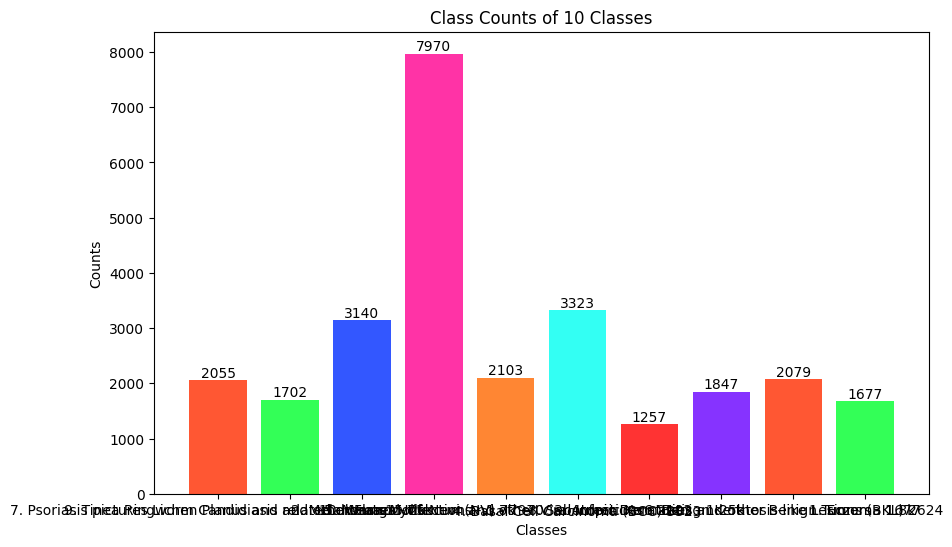

In [5]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 10 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

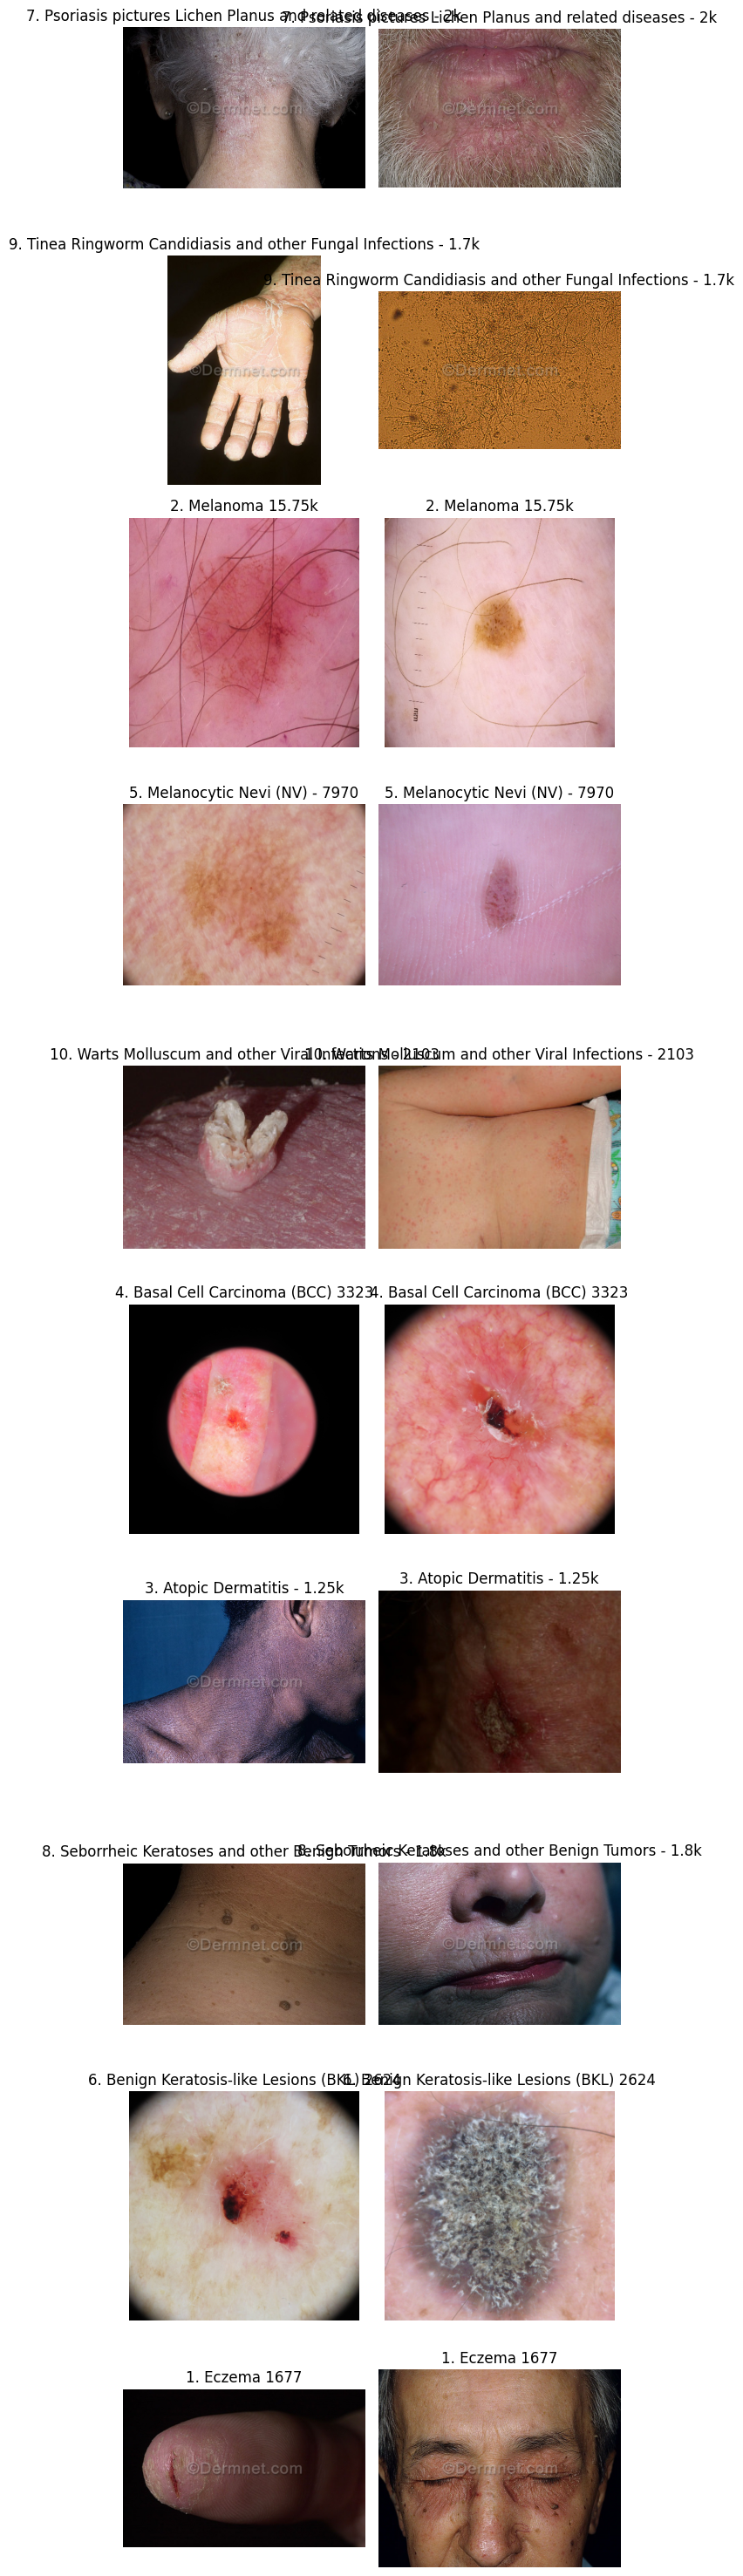

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Show 2 images from each class
num_images_per_class = 2
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(num_images_per_class * 3 ,len(classes) * 3))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(output_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

    for j in range(num_images_per_class):
        ax = axes[i, j] if len(classes) > 1 else axes[j]  # handle 1-class case
        if j < len(sample_images):
            img_path = os.path.join(class_dir, sample_images[j])
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(f"{class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target

    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []

        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [8]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Processed 7012/7000 images for 2. Melanoma 15.75k
Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Processed 7021/7000 images for 1. Eczema 1677
Oversampling and undersampling completed successfully.


Class counts: [6985, 6959, 6992, 7000, 6992, 6984, 6969, 6992, 6968, 6977]


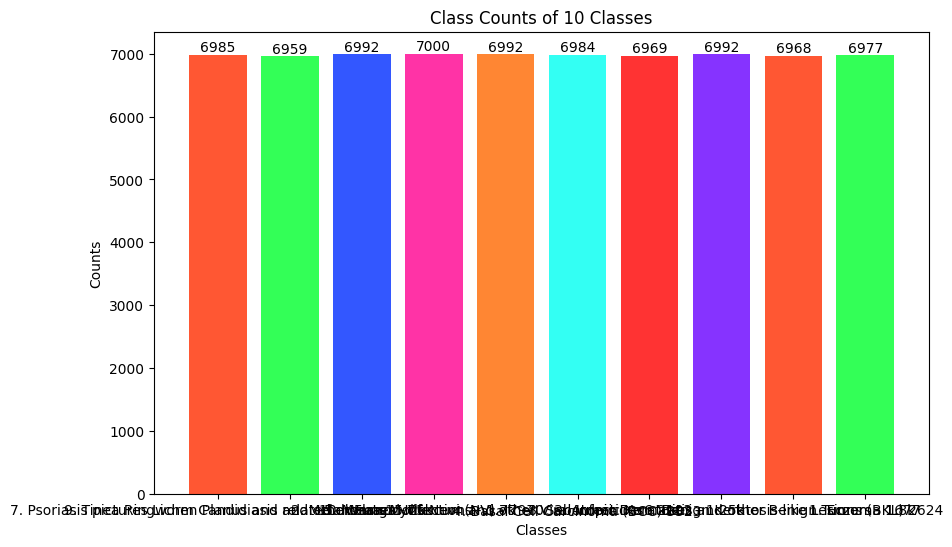

In [9]:
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 10 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

In [10]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)

    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)

    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


In [11]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)


Found 48868 files belonging to 10 classes.
Found 10467 files belonging to 10 classes.


In [12]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.convnext import preprocess_input

# Load base model (ConvNeXtBase or ConvNeXtTiny for smaller size)
base_model = ConvNeXtBase(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Freeze pretrained layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)  # adjust class count as needed

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Preprocessing datasets using ConvNeXt’s preprocess_input
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=7,
    callbacks=[lr_reduction]
)

# Final accuracy and loss
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")



350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Epoch 1/7
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 883s 559ms/step - accuracy: 0.5411 - loss: 1.3839 - val_accuracy: 0.8841 - val_loss: 0.3788 - learning_rate: 1.0000e-04
Epoch 2/7
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 788s 515ms/step - accuracy: 0.8048 - loss: 0.5757 - val_accuracy: 0.9038 - val_loss: 0.2940 - learning_rate: 1.0000e-04
Epoch 3/7
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 782s 511ms/step - accuracy: 0.8454 - loss: 0.4587 - val_accuracy: 0.9115 - val_loss: 0.2628 - learning_rate: 1.0000e-04
Epoch 4/7
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 803s 512ms/step - accuracy: 0.8679 - loss: 0.3911 - val_accuracy: 0.9161 - val_loss: 0.2422 - learning_rate: 1.0000e-04
Epoch 5/7
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 802s 512ms/step - accuracy: 0.8778 - loss: 0.3553 - val_accuracy: 0.9187 - val_loss: 0.2340 - learning_rate: 1.0000e-04
Epoch 6/7
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 801s 511ms/step - accuracy: 0.8854 - loss: 0.3288 - val_accuracy: 0.9221 - val_loss: 0.2204 - learni

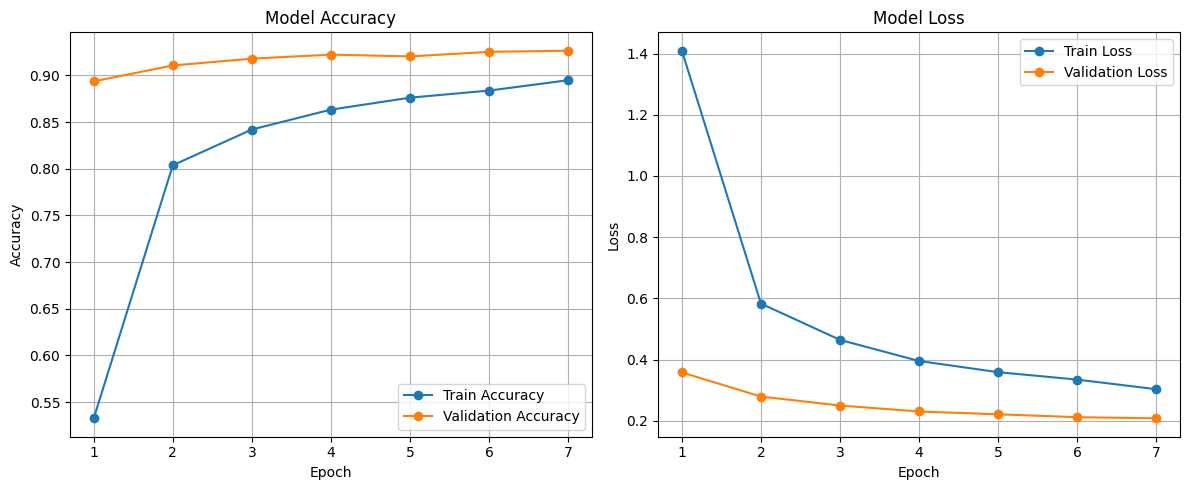

In [14]:
import matplotlib.pyplot as plt

# Metrics from each epoch
train_accuracy = [0.5326, 0.8037, 0.8420, 0.8633, 0.8761, 0.8837, 0.8948]
val_accuracy   = [0.8936, 0.9106, 0.9179, 0.9222, 0.9203, 0.9252, 0.9264]
train_loss     = [1.4092, 0.5827, 0.4641, 0.3951, 0.3586, 0.3343, 0.3029]
val_loss       = [0.3577, 0.2789, 0.2496, 0.2301, 0.2209, 0.2115, 0.2077]

epochs = range(1, len(train_accuracy) + 1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results_graph.png')  # Save as image
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

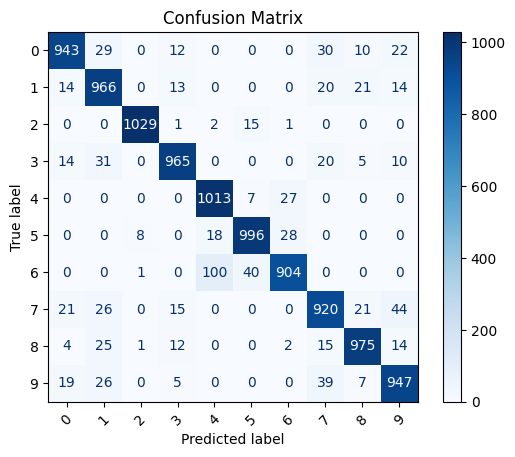

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gather true and predicted labels
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

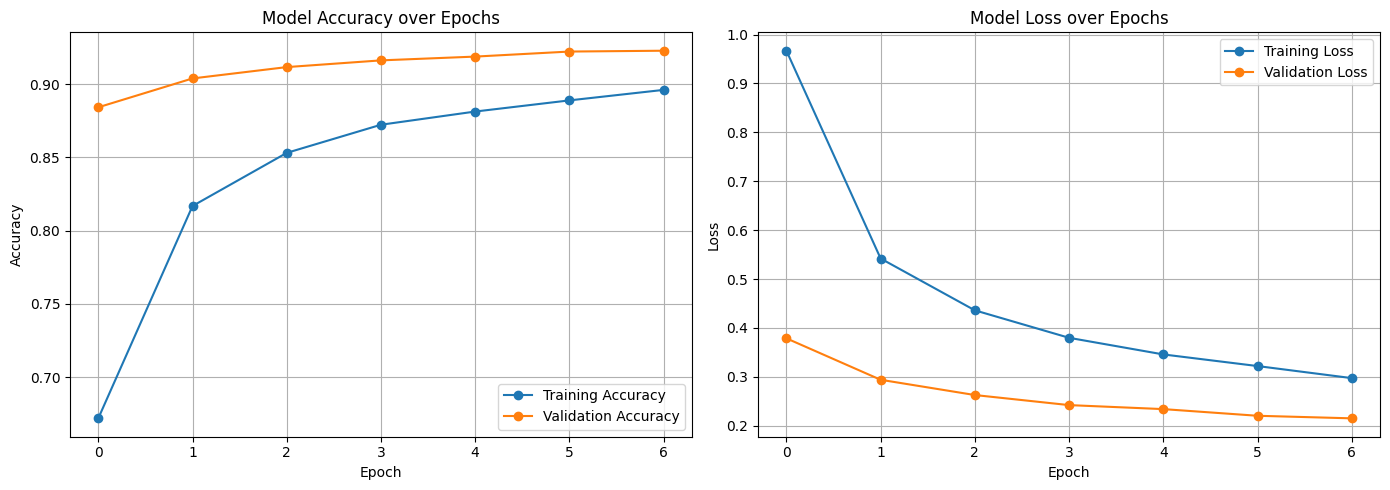

In [16]:
# Plot training vs validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()